In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from functools import reduce
from scipy import stats as stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
listings = pd.read_csv('seattle_airbnb_data.dir/listings.csv')
listings_filtered = pd.read_csv('listings_filtered.csv')
listings_filtered['monthly_profit_diff_high_end'] = listings_filtered['monthly_profit_high_end'] - listings_filtered['rent']

In [3]:
cols_tofit = ['id', 'monthly_profit_diff_high_end']
cols = ['id',         
        'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',        
        'host_response_rate', 'host_is_superhost', 'host_response_time', 'host_about',
        'first_review',
        'cancellation_policy', 'instant_bookable', 'extra_people', 'price',
        'amenities',
        'property_type', 'bedrooms', 'zipcode', 'transit']
combine = pd.merge(left = listings_filtered[cols_tofit],
                   right = listings[cols],
                   left_on = 'id',
                   right_on = 'id',
                   how = 'left')
combine.head()

,id,monthly_profit_diff_high_end,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,host_response_rate,host_is_superhost,host_response_time,host_about,first_review,cancellation_policy,instant_bookable,extra_people,price,amenities,property_type,bedrooms,zipcode,transit
0,241032,-476.733333,10.0,10.0,10.0,10.0,96%,f,within a few hours,"I am an artist, interior designer, and run a s...",2011-11-01,moderate,f,$5.00,$85.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Apartment,1.0,98119,NaN
1,953595,-484.285398,10.0,10.0,10.0,10.0,98%,t,within an hour,Living east coast/left coast/overseas. Time i...,2013-08-19,strict,f,$0.00,$150.00,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",Apartment,1.0,98119,"Convenient bus stops are just down the block, ..."
2,278830,-678.647164,9.0,9.0,10.0,10.0,100%,f,within an hour,"Hi, I live in Seattle, Washington but I'm orig...",2012-07-10,strict,f,$15.00,$450.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",House,3.0,98119,The nearest public transit bus (D Line) is 2 b...
3,2493658,-805.890430,10.0,10.0,10.0,10.0,98%,t,within an hour,Living east coast/left coast/overseas. Time i...,2014-04-27,strict,f,$0.00,$150.00,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",Apartment,1.0,98119,"Convenient bus stops are just down the block, ..."
4,175576,-642.676296,10.0,10.0,10.0,10.0,100%,t,within a few hours,Eileen and Ray were born in Seattle just three...,2011-07-21,moderate,f,$15.00,$95.00,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",House,1.0,98119,The bus stop is just two blocks from our house...


In [4]:
combine['host_response_rate'] = combine['host_response_rate'].str.strip('%').astype(float)

In [5]:
combine['has_host_about'] = np.where(~combine['host_about'].isna(), 't', 'f')
combine.drop(columns=['host_about'], inplace=True)

In [6]:
combine['first_review_days'] = (pd.to_datetime('2016-01-01') - pd.to_datetime(combine['first_review'])).apply(lambda x: x.days)
combine.drop(columns=['first_review'], inplace=True)

In [7]:
combine['extra_people'] = combine['extra_people'].str.strip('$').astype(float)
combine['price'] = combine['price'].str.strip('$').astype(float)

In [8]:
pat = re.compile('(\W|^)(bus|buses)(\W|$)')
combine['transit_type'] = combine['transit'].apply(lambda x: 'bus' if isinstance(x, str) and pat.search(x.lower()) else 'other')
combine.loc[combine.transit.isna(), 'transit_type'] = 'not_provided'
combine.drop(columns=['transit'], inplace=True)

In [9]:
combine['bedrooms'] = combine['bedrooms'].astype(str)

In [10]:
# some work on amenities
good_ones = ['Doorman', 'Hair Dryer', 'Laptop Friendly Workspace', 'Iron', 'Heating',
             '24-Hour Check-in', 'Shampoo', 'Hangers', 'Essentials', 'Essentials']
bad_ones = ['Indoor Fireplace', 'Hot Tub', 'Washer']
strange_ones = ['Free Parking on Premises', 'Family/Kid Friendly']

In [11]:
combine['amenities_unpacked'] = combine['amenities'].apply(lambda x: set(re.sub('[\{\}\"]', '', x).split(',')))

In [12]:
combine['good_amenities_counts'] = 0
combine['bad_amenities_counts'] = 0
combine['strange_amenities_counts'] = 0
for thing in good_ones:
    combine['good_amenities_counts'] += combine['amenities_unpacked'].apply(lambda x: thing in x).astype(int)
for thing in bad_ones:
    combine['bad_amenities_counts'] += combine['amenities_unpacked'].apply(lambda x: thing in x).astype(int)
for thing in strange_ones:
    combine['strange_amenities_counts'] += combine['amenities_unpacked'].apply(lambda x: thing in x).astype(int)

In [13]:
combine.drop(columns=['amenities_unpacked','amenities'], inplace=True)

In [14]:
reviews = pd.read_csv('seattle_airbnb_data.dir/reviews.csv')
pat = re.compile(r'(\W|^)(cat|kitten|dog|puppy)(\W|$)')
reviews['has_pet'] = reviews.comments.apply(lambda x: True if (isinstance(x,str) and pat.search(x.lower())) else False)
tmp = reviews.groupby('listing_id').agg({'has_pet':any})
combine = pd.merge(left=combine, right=tmp, left_on='id', right_on='listing_id', how='left')
combine['has_pet'] = np.where(combine['has_pet'], 't', 'f')

In [15]:
combine

,id,monthly_profit_diff_high_end,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,host_response_rate,host_is_superhost,host_response_time,cancellation_policy,...,property_type,bedrooms,zipcode,has_host_about,first_review_days,transit_type,good_amenities_counts,bad_amenities_counts,strange_amenities_counts,has_pet
0,241032,-476.733333,10.0,10.0,10.0,10.0,96.0,f,within a few hours,moderate,...,Apartment,1.0,98119,t,1522,not_provided,1,1,1,t
1,953595,-484.285398,10.0,10.0,10.0,10.0,98.0,t,within an hour,strict,...,Apartment,1.0,98119,t,865,bus,3,1,2,f
2,278830,-678.647164,9.0,9.0,10.0,10.0,100.0,f,within an hour,strict,...,House,3.0,98119,t,1270,bus,4,0,1,f
3,2493658,-805.890430,10.0,10.0,10.0,10.0,98.0,t,within an hour,strict,...,Apartment,1.0,98119,t,614,bus,3,1,2,f
4,175576,-642.676296,10.0,10.0,10.0,10.0,100.0,t,within a few hours,moderate,...,House,1.0,98119,t,1625,bus,9,1,1,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,262764,-1263.003620,9.0,8.0,10.0,10.0,100.0,f,within an hour,strict,...,House,2.0,98103,t,92,bus,8,1,1,f
1994,8578490,-1280.466667,9.0,8.0,10.0,10.0,100.0,f,within a few hours,moderate,...,Apartment,1.0,98103,f,92,bus,4,2,0,f
1995,3383329,-556.841355,10.0,10.0,10.0,10.0,100.0,t,within an hour,moderate,...,Apartment,1.0,98107,t,542,bus,9,2,2,f
1996,8101950,-1688.833333,8.0,10.0,4.0,8.0,99.0,f,within a few hours,strict,...,House,3.0,98107,f,96,not_provided,4,1,2,f


### i think that's it for all columns, let's fillna

In [16]:
combine.shape

(1998, 23)

In [17]:
combine.isna().sum()

id                                0
monthly_profit_diff_high_end      3
review_scores_accuracy           18
review_scores_cleanliness        16
review_scores_checkin            18
review_scores_communication      15
host_response_rate              187
host_is_superhost                 0
host_response_time              187
cancellation_policy               0
instant_bookable                  0
extra_people                      0
price                             0
property_type                     0
bedrooms                          0
zipcode                           3
has_host_about                    0
first_review_days                 0
transit_type                      0
good_amenities_counts             0
bad_amenities_counts              0
strange_amenities_counts          0
has_pet                           0
dtype: int64

In [18]:
combine.dropna(subset=['monthly_profit_diff_high_end', 'zipcode'], axis=0, inplace=True)

In [19]:
for col in ['review_scores_accuracy', 'review_scores_cleanliness', 
            'review_scores_checkin', 'review_scores_communication', 'host_response_rate']:
    x = combine[col].median()
    print(x)
    combine[col].fillna(x, inplace=True)

10.0
10.0
10.0
10.0
100.0


In [20]:
combine['host_response_time'].value_counts()

within an hour        950
within a few hours    530
within a day          313
a few days or more     15
Name: host_response_time, dtype: int64

In [21]:
combine['host_response_time'].fillna('within an hour', inplace=True)

In [22]:
combine.isna().sum(), combine.shape

(id                              0
 monthly_profit_diff_high_end    0
 review_scores_accuracy          0
 review_scores_cleanliness       0
 review_scores_checkin           0
 review_scores_communication     0
 host_response_rate              0
 host_is_superhost               0
 host_response_time              0
 cancellation_policy             0
 instant_bookable                0
 extra_people                    0
 price                           0
 property_type                   0
 bedrooms                        0
 zipcode                         0
 has_host_about                  0
 first_review_days               0
 transit_type                    0
 good_amenities_counts           0
 bad_amenities_counts            0
 strange_amenities_counts        0
 has_pet                         0
 dtype: int64,
 (1995, 23))

### finally get to modeling

In [23]:
dat = combine.drop(columns=['id']).copy()
dat.shape

(1995, 22)

In [24]:
def make_dummies(dat):
    '''
       if: it's t vs f, drop f
       else: dropping the most common when making dummies
    '''
    def _join(col, val):
        return '_'.join(['dummy', col, val])
    
    cols_cat = dat.columns[dat.dtypes == 'object']
    cols_to_drop = []
    cols_to_rename = {}
    for col in cols_cat:
        tmp = dat[col].value_counts().sort_values(ascending=False)
        if set(tmp.index) == {'t','f'}:
            cols_to_drop.append(_join(col, 'f'))
        else:
            val_ref = tmp.index[0]
            cols_to_drop.append(_join(col, val_ref))
            for val in tmp.index[1:]:
                cols_to_rename[_join(col, val)] = _join(col, val) + '_vs_' + val_ref
                
    dat = pd.get_dummies(dat,
                         columns = cols_cat,
                         prefix = ['dummy_'+x for x in cols_cat])
    dat = dat.drop(columns=cols_to_drop)
    print(dat.columns)
    print(cols_to_rename)
    dat.columns = [cols_to_rename[x] if x in cols_to_rename else x for x in list(dat.columns)]
    return dat

In [25]:
dat.columns.rename

<bound method Index.rename of Index(['monthly_profit_diff_high_end', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'host_response_rate',
       'host_is_superhost', 'host_response_time', 'cancellation_policy',
       'instant_bookable', 'extra_people', 'price', 'property_type',
       'bedrooms', 'zipcode', 'has_host_about', 'first_review_days',
       'transit_type', 'good_amenities_counts', 'bad_amenities_counts',
       'strange_amenities_counts', 'has_pet'],
      dtype='object')>

In [26]:
dat = make_dummies(dat)
dat

Index(['monthly_profit_diff_high_end', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'host_response_rate', 'extra_people',
       'price', 'first_review_days', 'good_amenities_counts',
       'bad_amenities_counts', 'strange_amenities_counts',
       'dummy_host_is_superhost_t',
       'dummy_host_response_time_a few days or more',
       'dummy_host_response_time_within a day',
       'dummy_host_response_time_within a few hours',
       'dummy_cancellation_policy_flexible',
       'dummy_cancellation_policy_moderate', 'dummy_instant_bookable_t',
       'dummy_property_type_Condominium', 'dummy_property_type_House',
       'dummy_property_type_Loft', 'dummy_property_type_Townhouse',
       'dummy_bedrooms_0.0', 'dummy_bedrooms_2.0', 'dummy_bedrooms_3.0',
       'dummy_bedrooms_4.0', 'dummy_zipcode_98101', 'dummy_zipcode_98102',
       'dummy_zipcode_98103', 'dummy_zipcode_98104', 'dummy_zipcode_98105',
    

,monthly_profit_diff_high_end,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,host_response_rate,extra_people,price,first_review_days,good_amenities_counts,...,dummy_zipcode_98136_vs_98122,dummy_zipcode_98144_vs_98122,dummy_zipcode_98146_vs_98122,dummy_zipcode_98177_vs_98122,dummy_zipcode_98178_vs_98122,dummy_zipcode_98199_vs_98122,dummy_has_host_about_t,dummy_transit_type_not_provided_vs_bus,dummy_transit_type_other_vs_bus,dummy_has_pet_t
0,-476.733333,10.0,10.0,10.0,10.0,96.0,5.0,85.0,1522,1,...,0,0,0,0,0,0,1,1,0,1
1,-484.285398,10.0,10.0,10.0,10.0,98.0,0.0,150.0,865,3,...,0,0,0,0,0,0,1,0,0,0
2,-678.647164,9.0,9.0,10.0,10.0,100.0,15.0,450.0,1270,4,...,0,0,0,0,0,0,1,0,0,0
3,-805.890430,10.0,10.0,10.0,10.0,98.0,0.0,150.0,614,3,...,0,0,0,0,0,0,1,0,0,0
4,-642.676296,10.0,10.0,10.0,10.0,100.0,15.0,95.0,1625,9,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,-1263.003620,9.0,8.0,10.0,10.0,100.0,50.0,154.0,92,8,...,0,0,0,0,0,0,1,0,0,0
1994,-1280.466667,9.0,8.0,10.0,10.0,100.0,0.0,65.0,92,4,...,0,0,0,0,0,0,0,0,0,0
1995,-556.841355,10.0,10.0,10.0,10.0,100.0,8.0,95.0,542,9,...,0,0,0,0,0,0,1,0,0,0
1996,-1688.833333,8.0,10.0,4.0,8.0,99.0,0.0,359.0,96,4,...,0,0,0,0,0,0,0,1,0,0


In [27]:
def preprocess(dat, y_col):
    cols_cat, cols_num = [], []
    for col in dat.columns:
        if col.startswith('dummy'):
            cols_cat.append(col)
        else:
            cols_num.append(col)
    cols_num.remove(y_col)
    X1 = dat[cols_num].values
    X2 = dat[cols_cat].values
    y = dat[y_col].values
    X1 = StandardScaler().fit_transform(X1)
    X = np.concatenate((X1, X2), axis=1)
    return X, y, cols_num + cols_cat

In [28]:
X, y, cols = preprocess(dat, 'monthly_profit_diff_high_end')

In [29]:
reg = GridSearchCV(Ridge(), param_grid={'alpha':[0.1,0.5,1.0,5.0,10.0,50.0,100]}, scoring='neg_mean_absolute_error')
reg.fit(X, y)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100]},
             scoring='neg_mean_absolute_error')

In [30]:
reg.cv_results_

{'mean_fit_time': array([0.00327802, 0.00128841, 0.0015677 , 0.00392194, 0.00122509,
        0.00119352, 0.00129356]),
 'std_fit_time': array([1.03958489e-03, 9.90284132e-05, 3.81605887e-04, 5.00671931e-03,
        2.27619705e-05, 6.79890199e-06, 2.27139717e-05]),
 'mean_score_time': array([0.0008184 , 0.00032969, 0.00035143, 0.00136838, 0.00029697,
        0.0002944 , 0.00031857]),
 'std_score_time': array([4.93836204e-04, 6.70520877e-05, 3.60518535e-05, 2.12505917e-03,
        6.14472721e-06, 2.60040249e-06, 3.39949781e-05]),
 'param_alpha': masked_array(data=[0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1},
  {'alpha': 0.5},
  {'alpha': 1.0},
  {'alpha': 5.0},
  {'alpha': 10.0},
  {'alpha': 50.0},
  {'alpha': 100}],
 'split0_test_score': array([-213.54107542, -213.72946669, -213.86265173, -214.83993498,
        -216.97027099, -230.24331615, -238.

In [31]:
def importance_plot(reg, cols, figsize=(10,20)):
    tmp = pd.DataFrame(reg.best_estimator_.coef_, index=cols)
    tmp.reset_index(inplace=True)
    tmp.columns = ('feature','importance')
    plt.figure(figsize = figsize)
    sns.barplot(data = tmp,
                x = 'importance',
                y = 'feature',
                order = tmp.sort_values(by='importance').feature)

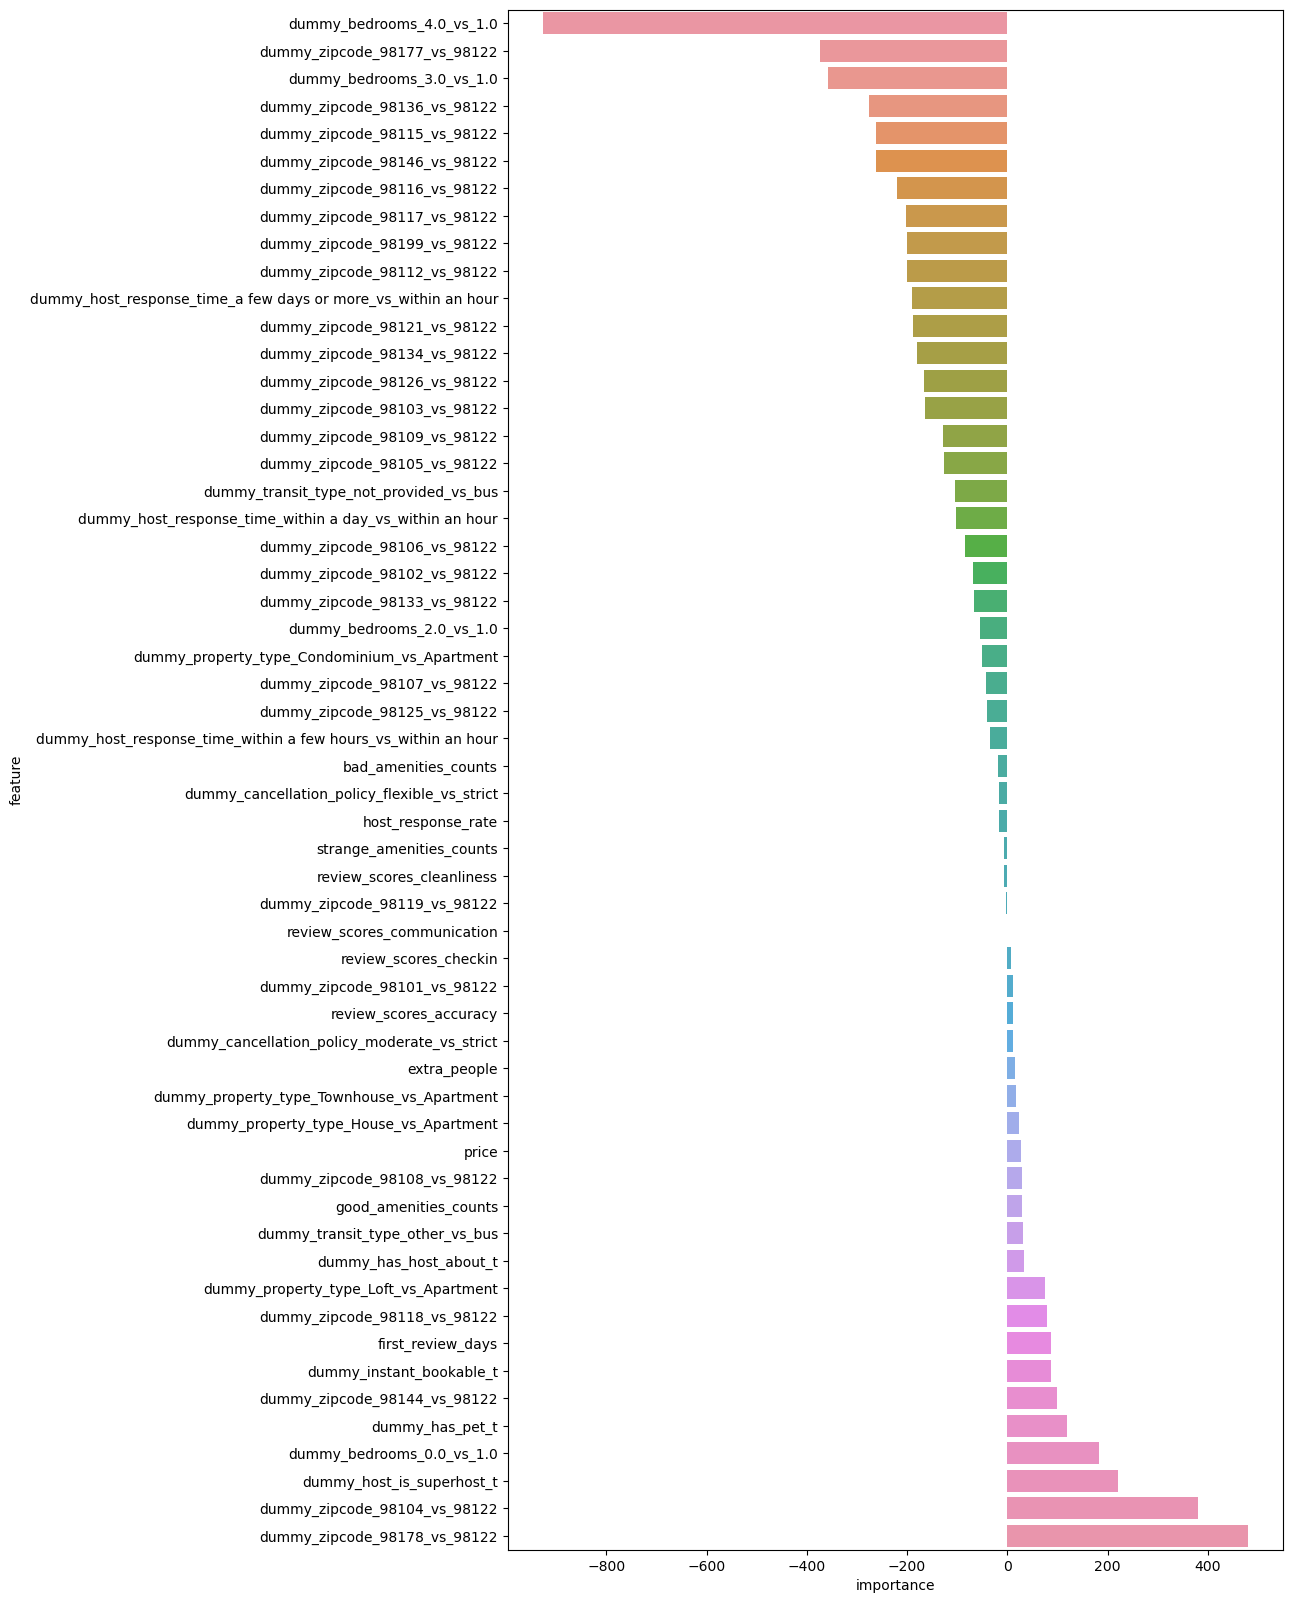

In [32]:
importance_plot(reg, cols)

### i mean, this is just ugly and not saying too much, with zip code/bedrooms being the most important things, which we already know; it also confirms that being superhost, has_pet, etc are important; let's remove the zip code /bedroom average to see to if it produces more actionable options

In [33]:
dat = combine.drop(columns=['id']).copy()

In [34]:
tmp = dat.groupby(['zipcode','bedrooms']).agg({'monthly_profit_diff_high_end':'mean'})
tmp.reset_index(inplace=True)
tmp.columns = ['zipcode','bedrooms','mean']
tmp

,zipcode,bedrooms,mean
0,98101,0.0,-638.581458
1,98101,1.0,-895.788923
2,98101,2.0,-967.567673
3,98101,3.0,-1574.503405
4,98102,0.0,-892.883759
...,...,...,...
109,98199,0.0,-1092.620608
110,98199,1.0,-1091.175594
111,98199,2.0,-1302.073973
112,98199,3.0,-1376.464649


In [35]:
dat = pd.merge(left=dat, right=tmp, how='left',
               left_on = ['zipcode','bedrooms'],
               right_on = ['zipcode','bedrooms'])

In [36]:
dat['monthly_profit_diff_high_end_demean'] = dat['monthly_profit_diff_high_end'] - dat['mean']
dat.drop(columns=['monthly_profit_diff_high_end', 'mean','zipcode','bedrooms'], inplace=True)

In [37]:
dat = make_dummies(dat)
dat

Index(['review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'host_response_rate', 'extra_people', 'price', 'first_review_days',
       'good_amenities_counts', 'bad_amenities_counts',
       'strange_amenities_counts', 'monthly_profit_diff_high_end_demean',
       'dummy_host_is_superhost_t',
       'dummy_host_response_time_a few days or more',
       'dummy_host_response_time_within a day',
       'dummy_host_response_time_within a few hours',
       'dummy_cancellation_policy_flexible',
       'dummy_cancellation_policy_moderate', 'dummy_instant_bookable_t',
       'dummy_property_type_Condominium', 'dummy_property_type_House',
       'dummy_property_type_Loft', 'dummy_property_type_Townhouse',
       'dummy_has_host_about_t', 'dummy_transit_type_not_provided',
       'dummy_transit_type_other', 'dummy_has_pet_t'],
      dtype='object')
{'dummy_host_response_time_within a few hours': 'dummy_host_response_time_wi

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,host_response_rate,extra_people,price,first_review_days,good_amenities_counts,bad_amenities_counts,...,dummy_cancellation_policy_moderate_vs_strict,dummy_instant_bookable_t,dummy_property_type_Condominium_vs_Apartment,dummy_property_type_House_vs_Apartment,dummy_property_type_Loft_vs_Apartment,dummy_property_type_Townhouse_vs_Apartment,dummy_has_host_about_t,dummy_transit_type_not_provided_vs_bus,dummy_transit_type_other_vs_bus,dummy_has_pet_t
0,10.0,10.0,10.0,10.0,96.0,5.0,85.0,1522,1,1,...,1,0,0,0,0,0,1,1,0,1
1,10.0,10.0,10.0,10.0,98.0,0.0,150.0,865,3,1,...,0,0,0,0,0,0,1,0,0,0
2,9.0,9.0,10.0,10.0,100.0,15.0,450.0,1270,4,0,...,0,0,0,1,0,0,1,0,0,0
3,10.0,10.0,10.0,10.0,98.0,0.0,150.0,614,3,1,...,0,0,0,0,0,0,1,0,0,0
4,10.0,10.0,10.0,10.0,100.0,15.0,95.0,1625,9,1,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,9.0,8.0,10.0,10.0,100.0,50.0,154.0,92,8,1,...,0,0,0,1,0,0,1,0,0,0
1991,9.0,8.0,10.0,10.0,100.0,0.0,65.0,92,4,2,...,1,0,0,0,0,0,0,0,0,0
1992,10.0,10.0,10.0,10.0,100.0,8.0,95.0,542,9,2,...,1,1,0,0,0,0,1,0,0,0
1993,8.0,10.0,4.0,8.0,99.0,0.0,359.0,96,4,1,...,0,0,0,1,0,0,0,1,0,0


In [38]:
X, y, cols = preprocess(dat, 'monthly_profit_diff_high_end_demean')

In [39]:
reg = GridSearchCV(Ridge(), param_grid={'alpha':np.arange(100)}, scoring='neg_mean_absolute_error')
reg.fit(X, y)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             scoring='neg_mean_absolute_error')

In [40]:
reg.cv_results_

{'mean_fit_time': array([0.00135756, 0.00155878, 0.00094681, 0.00097103, 0.00084858,
        0.00092745, 0.00098329, 0.00081115, 0.00091438, 0.0008852 ,
        0.00081811, 0.00079861, 0.00079694, 0.00082626, 0.0007956 ,
        0.00085196, 0.00080066, 0.00080409, 0.00114894, 0.00080681,
        0.00079875, 0.00079136, 0.00079188, 0.00081129, 0.00082498,
        0.00085249, 0.00080543, 0.00079107, 0.00082374, 0.00079198,
        0.00079522, 0.00079751, 0.00080228, 0.00079441, 0.0008008 ,
        0.00079703, 0.00078979, 0.00080571, 0.00079312, 0.00079441,
        0.00079165, 0.00080066, 0.00079851, 0.00080118, 0.00079107,
        0.00078754, 0.00080185, 0.00079584, 0.00082002, 0.00079107,
        0.00079613, 0.00080571, 0.00080843, 0.00079932, 0.00079417,
        0.00079207, 0.0007895 , 0.0007977 , 0.00079274, 0.00079632,
        0.00079107, 0.00080848, 0.00078826, 0.00079207, 0.00078874,
        0.00079484, 0.00079203, 0.00078788, 0.0008234 , 0.00086365,
        0.00079608, 0.00078754,

In [41]:
combine.host_response_time.value_counts()

within an hour        1137
within a few hours     530
within a day           313
a few days or more      15
Name: host_response_time, dtype: int64

In [42]:
combine.cancellation_policy.value_counts()

strict      926
moderate    689
flexible    380
Name: cancellation_policy, dtype: int64

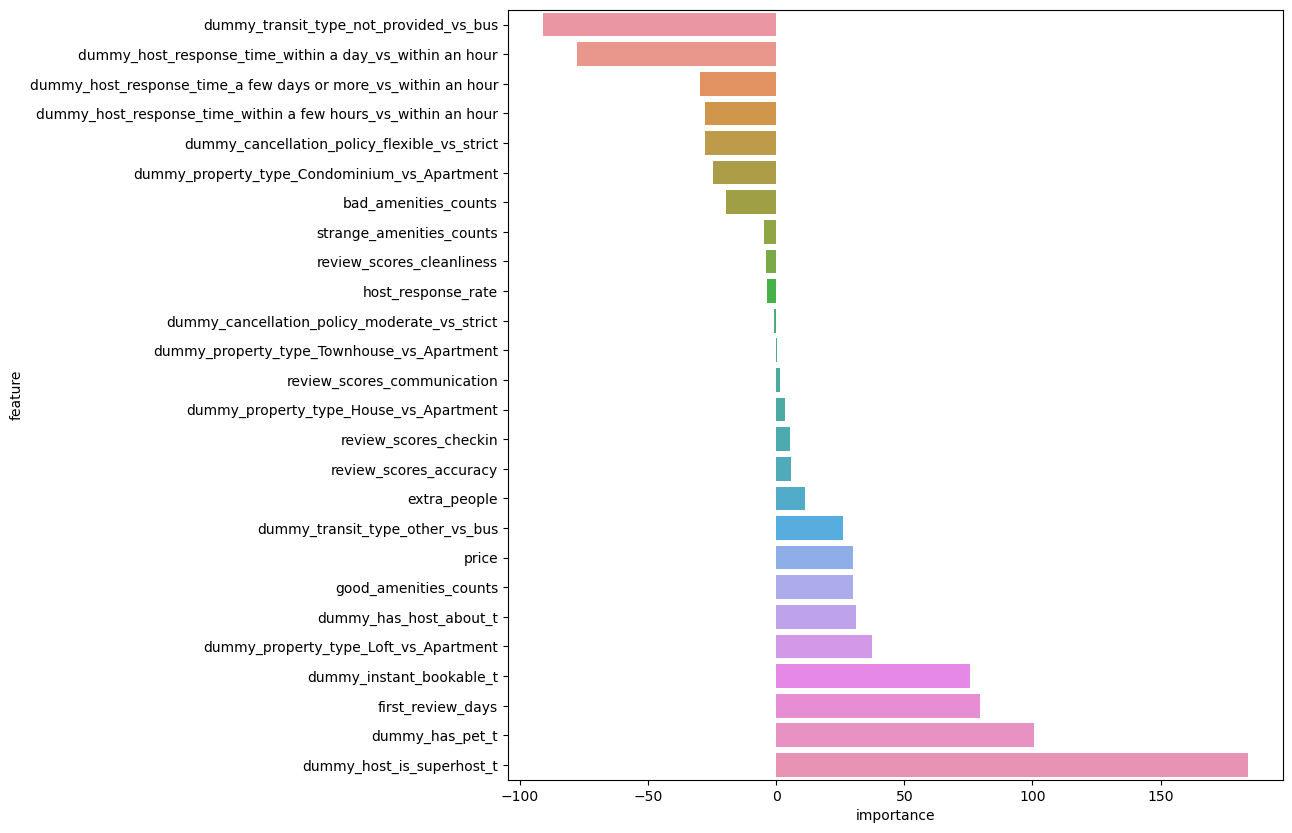

In [43]:
importance_plot(reg, cols, figsize=(10,10))

In [44]:
cols

['review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'host_response_rate',
 'extra_people',
 'price',
 'first_review_days',
 'good_amenities_counts',
 'bad_amenities_counts',
 'strange_amenities_counts',
 'dummy_host_is_superhost_t',
 'dummy_host_response_time_a few days or more_vs_within an hour',
 'dummy_host_response_time_within a day_vs_within an hour',
 'dummy_host_response_time_within a few hours_vs_within an hour',
 'dummy_cancellation_policy_flexible_vs_strict',
 'dummy_cancellation_policy_moderate_vs_strict',
 'dummy_instant_bookable_t',
 'dummy_property_type_Condominium_vs_Apartment',
 'dummy_property_type_House_vs_Apartment',
 'dummy_property_type_Loft_vs_Apartment',
 'dummy_property_type_Townhouse_vs_Apartment',
 'dummy_has_host_about_t',
 'dummy_transit_type_not_provided_vs_bus',
 'dummy_transit_type_other_vs_bus',
 'dummy_has_pet_t']